In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from torch.optim import AdamW
import numpy as np
import rsa

# --- Classe Principale Greedy DDPM ---

class GreedyDDPM:
    def __init__(self, model_id, device="cuda"):
        self.device = device
        self.model_id = model_id

        # Chargement du modèle
        self.pipeline = DDPMPipeline.from_pretrained(model_id)
        self.unet = self.pipeline.unet.to(device)
        self.scheduler = self.pipeline.scheduler

        # Configuration par défaut
        self.config = {
            "layer_name": "mid_block.resnets.0.conv1.weight",  # Couche cible
            "message": "DDPM_WATERMARK",      # Message à encoder
            "objective_size": (32, 64),     # (watermark_bits, weights_per_bit)
            "ratio": 0.5,                     # Ratio de pruning
            "threshold": 0.1,                 # Seuil pour la loss
            "lambda_wat": 0.01,               # Poids de la watermark loss
            "lr": 1e-4,
            "epochs": 30
        }

        self.saved_keys = {}

    def _get_target_layer(self, model):
        """Récupère le tenseur des poids de la couche cible."""
        for name, param in model.named_parameters():
            if name == self.config["layer_name"]:
                return param
        raise ValueError(f"Paramètre {self.config['layer_name']} introuvable.")

    # def keygen(self, message):
    #     """
    #     Génère le watermark à partir d'un message via signature RSA.
    #     Returns:
    #         watermark_sig: Watermark en {-1, +1} (256 bits)
    #         watermark: Watermark binaire en {0, 1}
    #     """
    #     # Génération des clés RSA
    #     # (pubkey, privkey) = rsa.newkeys(512)
    #     # message_bytes = message.encode('utf-8')
    #
    #     # Signature et hash
    #     # signature = rsa.sign(message_bytes, privkey, 'SHA-256')
    #     # signature_hash = rsa.compute_hash(signature, 'SHA-256')
    #
    #     # Conversion hex -> bin (256 bits)
    #     b_sig = list(bin(int(signature_hash.hex(), 16))[2:].zfill(256))
    #     b_sig = list(map(int, b_sig))
    #
    #     watermark_size = self.config.get("watermark_size", 256)
    #     b_sig = b_sig[:watermark_size]  # Take first 32 bits
    #
    #     # Conversion en tenseurs
    #     watermark_sig = torch.tensor(
    #         [-1.0 if i == 0 else 1.0 for i in b_sig],
    #         dtype=torch.float
    #     ).to(self.device)
    #
    #     watermark = torch.tensor(b_sig, dtype=torch.float32).to(self.device)
    #
    #     return watermark_sig, watermark



    def keygen(self, message):
        """
        Génère un watermark aléatoire basé sur le message.
        Returns:
            watermark_sig: Watermark en {-1, +1}
            watermark: Watermark binaire en {0, 1}
        """
        watermark_size = self.config.get("watermark_size", 32)

        # Set seed based on message for reproducibility
        seed = hash(message) % (2**32)
        torch.manual_seed(seed)

        # Generate random binary watermark {0, 1}
        b_sig = torch.randint(0, 2, (watermark_size,)).tolist()

        # Convert to signs: 0 -> -1, 1 -> +1
        watermark_sig = torch.tensor(
            [-1.0 if i == 0 else 1.0 for i in b_sig],
            dtype=torch.float
        ).to(self.device)

        # Binary watermark {0, 1}
        watermark = torch.tensor(b_sig, dtype=torch.float32).to(self.device)

        return watermark_sig, watermark

    def weight_extraction(self, model):
        """
        Extrait et reshape les poids de la couche cible.
        Returns:
            Tensor de taille objective_size
        """
        target_param = self._get_target_layer(model)
        
        # Flatten les poids
        layer_weight = target_param.view(-1)
        
        # Tronquer pour être divisible par objective_size[1]
        obj_size = self.config['objective_size']
        total_needed = obj_size[0] * obj_size[1]
        
        if layer_weight.numel() < total_needed:
            raise ValueError(
                f"Layer has {layer_weight.numel()} weights, "
                f"but objective_size requires {total_needed}"
            )
        
        # Adaptive average pooling pour obtenir la bonne taille
        truncated = layer_weight[:layer_weight.numel() // obj_size[1] * obj_size[1]]
        pooled = F.adaptive_avg_pool1d(
            truncated[None, None], 
            obj_size[0] * obj_size[1]
        ).squeeze(0).view(obj_size)
        
        return pooled

    # def compute_residuals(self, weight_matrix):
    #     """
    #     Calcule le vecteur résiduel après pruning.
    #
    #     Args:
    #         weight_matrix: Tensor de taille (num_rows, num_cols)
    #
    #     Returns:
    #         residual_vector: Tensor de taille (num_rows,)
    #     """
    #     num_rows, num_cols = weight_matrix.shape
    #
    #     # Nombre de poids à pruner (les plus petits en valeur absolue)
    #     num_to_prune = int(num_cols * self.config['ratio'] + 0.5)
    #
    #     # Clone pour éviter de modifier l'original
    #     weights_copy = weight_matrix.clone()
    #
    #     # Trier par valeur absolue et obtenir les indices
    #     sorted_indices = torch.argsort(torch.abs(weights_copy), dim=1)
    #
    #     # Indices des poids les plus petits à pruner
    #     prune_indices = sorted_indices[:, :num_to_prune]
    #
    #     # Mettre à zéro les poids prunés
    #     for row in range(num_rows):
    #         weights_copy[row, prune_indices[row]] = 0
    #
    #     # Moyenne de chaque ligne après pruning
    #     residual_vector = torch.mean(weights_copy, dim=1)
    #
    #     return residual_vector

    def compute_residuals(self, weight_matrix):
        """Vectorized version - much faster."""
        num_rows, num_cols = weight_matrix.shape
        num_to_prune = int(num_cols * self.config['ratio'] + 0.5)

        weights_copy = weight_matrix.clone()

        # Vectorized pruning - no for loop!
        sorted_indices = torch.argsort(torch.abs(weights_copy), dim=1)

        # Create mask for weights to zero out
        mask = torch.ones_like(weights_copy, dtype=torch.bool)
        rows = torch.arange(num_rows, device=weights_copy.device).unsqueeze(1)
        mask[rows, sorted_indices[:, :num_to_prune]] = False

        # Apply mask
        weights_copy = weights_copy * mask

        # Mean of each row
        residual_vector = torch.mean(weights_copy, dim=1)

        return residual_vector



    @staticmethod
    def _compute_ber(extracted, target):
        """Calcule le Bit Error Rate."""
        return (extracted != target).float().mean().item()

    def embed(self, dataloader):
        """
        Incorpore le watermark Greedy pendant le finetuning.
        """
        print(f"--- Démarrage Embedding GREEDY ({self.config['layer_name']}) ---")
        print(f"Message: {self.config['message']}")
        print(f"Objective size: {self.config['objective_size']}")
        print(f"Pruning ratio: {self.config['ratio']}")

        watermarked_unet = self.unet
        watermarked_unet.train()

        # 1. Génération des clés (watermark de 256 bits)
        watermark_sig, watermark = self.keygen(self.config["message"])
        
        # # Ajuster objective_size si nécessaire pour correspondre à 256 bits
        # if self.config['objective_size'][0] != 64:
        #     print(f"⚠️ Adjusting objective_size[0] to 256 (watermark size)")
        #     self.config['objective_size'] = (64, self.config['objective_size'][1])
        # Adjust objective_size to match watermark_size
        watermark_size = self.config.get("watermark_size",32)
        if self.config['objective_size'][0] != watermark_size:
            print(f"⚠️ Adjusting objective_size[0] to {watermark_size} (watermark size)")
            self.config['objective_size'] = (watermark_size, self.config['objective_size'][1])
        print(f"Watermark size: {len(watermark)} bits")

        # 2. Vérification initiale
        weight_extract = self.weight_extraction(watermarked_unet)
        residual_vector = self.compute_residuals(weight_extract)
        print(f"Initial residual vector shape: {residual_vector.shape}")

        # 3. Optimiseur
        optimizer = torch.optim.AdamW(watermarked_unet.parameters(), lr=self.config["lr"])
        mse_loss = nn.MSELoss()

        # 4. Boucle d'entraînement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{self.config['epochs']}")
            for batch_idx, (clean_images, _) in enumerate(pbar):
            # for clean_images, _ in pbar:
                clean_images = clean_images.to(self.device)
                bs = clean_images.shape[0]

                # A. Processus de Diffusion (Forward)
                noise = torch.randn_like(clean_images).to(self.device)
                timesteps = torch.randint(
                    0, self.scheduler.config.num_train_timesteps, 
                    (bs,), device=self.device
                ).long()
                noisy_images = self.scheduler.add_noise(clean_images, noise, timesteps)

                optimizer.zero_grad()

                # B. Prédiction (Task Loss)
                noise_pred = watermarked_unet(noisy_images, timesteps).sample
                l_main = mse_loss(noise_pred, noise)

                # C. Watermark Loss (Greedy regularization)
                weight_extract = self.weight_extraction(watermarked_unet)
                residual_vector = self.compute_residuals(weight_extract)
                
                # Loss: encourage residual signs to match watermark signs
                # l_wat = ReLU(threshold - watermark_sig * residual_vector)
                l_wat = F.relu(
                    self.config['threshold'] - 
                    (watermark_sig * residual_vector)
                ).sum()

                # Loss Totale
                l_total = l_main + self.config["lambda_wat"] * l_wat

                l_total.backward()
                optimizer.step()

                # D. Calcul du BER
                if batch_idx % 10 == 0:
                    ber, _ = self._extract_internal(watermarked_unet, watermark)

                pbar.set_postfix(
                    L_Main=f"{l_main.item():.4f}", 
                    L_Wat=f"{l_wat.item():.4f}",
                    BER=f"{ber:.4f}"
                )

                # Early stopping si BER = 0
                # if ber == 0.0 and l_wat.item() < 0.01:
                #     print("✅ Convergence atteinte!")
                #     break
            
            # if ber == 0.0:
            #     break

        # Sauvegarde des clés
        self.saved_keys = {
            "watermark": watermark,
            "watermark_sig": watermark_sig,
            "watermarked_unet": watermarked_unet
        }
        
        print(f"\n✅ Embedding terminé! BER final: {ber:.4f}")
        return watermarked_unet

    def _extract_internal(self, model, watermark):
        """
        Extraction interne (utilisée pendant l'embedding).
        """
        with torch.no_grad():
            weight_extract = self.weight_extraction(model)
            residual_vector = self.compute_residuals(weight_extract)
            
            # Prendre le signe des résidus
            signs = torch.sign(residual_vector)
            
            # Convertir -1 -> 0 pour obtenir le watermark binaire
            extracted_wm = signs.clone()
            extracted_wm[extracted_wm == -1] = 0
            
            ber = self._compute_ber(extracted_wm, watermark)
        
        return ber, extracted_wm

    def extract(self, suspect_unet=None):
        """
        Extrait le watermark d'un modèle suspect.
        """
        if suspect_unet is None:
            suspect_unet = self.saved_keys["watermarked_unet"]

        watermark = self.saved_keys["watermark"]

        # 1. Extraction des poids et calcul des résidus
        try:
            weight_extract = self.weight_extraction(suspect_unet)
            residual_vector = self.compute_residuals(weight_extract)
        except ValueError as e:
            print(f"⚠️ Erreur lors de l'extraction: {e}")
            return 1.0, None

        # 2. Calcul du watermark extrait
        signs = torch.sign(residual_vector)
        extracted_wm = signs.clone()
        extracted_wm[extracted_wm == -1] = 0

        # 3. Calcul du BER
        ber = self._compute_ber(extracted_wm, watermark)

        print(f"BER Extrait: {ber:.4f}")
        return ber, extracted_wm


/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- EXEMPLE D'EXÉCUTION ---

# 1. Setup Data
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 2. Embedding Greedy
greedy_defense = GreedyDDPM("google/ddpm-cifar10-32")

# Configuration optionnelle
greedy_defense.config.update({
    "message": "MY_DDPM_MODEL_2024",  # Message personnalisé
     "watermark_size": 32,
    "objective_size": (32, 64),      # (watermark_bits, weights_per_bit)
    "ratio": 0.5,                      # Pruning ratio
    "threshold": 0.1,                  # Margin threshold
    "lambda_wat": 0.01,                # Watermark loss weight
    "epochs": 30,
    "lr": 1e-4
})

watermarked_model = greedy_defense.embed(dataloader)

In [3]:
# 3. Test d'extraction sur le modèle watermarké
print("\n--- Test Extraction sur modèle watermarké ---")
ber, extracted_wm = greedy_defense.extract()
print(f"Watermark original: {greedy_defense.saved_keys['watermark'][:20]}...")
print(f"Watermark extrait:  {extracted_wm[:20]}...")

Watermark extrait:  tensor([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 0.], device='cuda:0', grad_fn=<SliceBackward0>)...


In [4]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack_greedy(greedy_obj, dataloader, epochs=5, lr=1e-4):
    """
    Tente de transférer la fonctionnalité du modèle Greedy vers un modèle vierge.
    Vérifie si la marque (basée sur les résidus des poids) survit.
    """
    device = greedy_obj.device

    # 1. Teacher (Gelé)
    teacher_unet = greedy_obj.saved_keys["watermarked_unet"]
    teacher_unet.eval()
    for p in teacher_unet.parameters():
        p.requires_grad = False

    # 2. Student (Vierge - Même architecture)
    print("\n--- Initialisation du Student ---")
    student_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
    student_unet = student_pipeline.unet.to(device)
    student_unet.train()

    # Sanity Checks
    teacher_ber, _ = greedy_obj.extract(teacher_unet)
    student_ber, _ = greedy_obj.extract(student_unet)
    print(f"[Check] BER Teacher: {teacher_ber:.4f}")
    print(f"[Check] BER Student (Avant): {student_ber:.4f}")

    optimizer = AdamW(student_unet.parameters(), lr=lr)
    noise_scheduler = greedy_obj.scheduler
    history = {"loss": [], "ber": []}

    print(f"\n--- Distillation Greedy ({epochs} epochs) ---")

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0

        for clean_images, _ in pbar:
            clean_images = clean_images.to(device)
            bs = clean_images.shape[0]

            # A. Input Noise
            noise = torch.randn_like(clean_images).to(device)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, 
                (bs,), device=device
            ).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # B. Distillation (Output Matching)
            with torch.no_grad():
                target_pred = teacher_unet(noisy_images, timesteps).sample

            student_pred = student_unet(noisy_images, timesteps).sample

            loss = F.mse_loss(student_pred, target_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(Loss=loss.item())

        # C. Vérification du BER après chaque epoch
        current_ber, _ = greedy_obj.extract(student_unet)
        history["ber"].append(current_ber)
        history["loss"].append(running_loss / len(dataloader))

        print(f"👉 Fin Epoch {epoch+1} | Loss: {loss.item():.4f} | BER Student: {current_ber:.4f}")

    return student_unet, history

In [5]:
# 4. Attaque par Distillation
student_model, attack_stats = run_distillation_attack_greedy(
    greedy_defense, 
    dataloader, 
    epochs=100
)

In [ ]:
student_model, attack_stats = run_distillation_attack_greedy(
    greedy_defense,
    dataloader,
    epochs=100
)

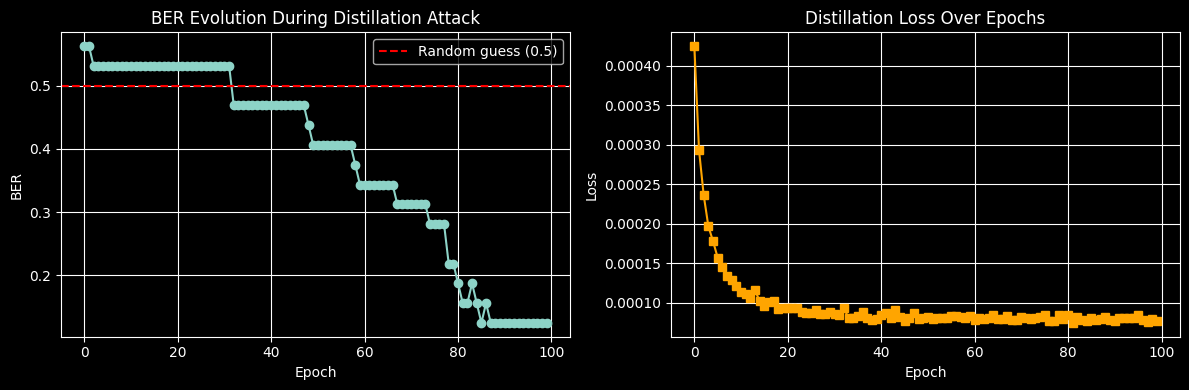

In [6]:
# 5. Visualisation des résultats
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# BER over epochs
axes[0].plot(attack_stats["ber"], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BER')
axes[0].set_title('BER Evolution During Distillation Attack')
axes[0].axhline(y=0.5, color='r', linestyle='--', label='Random guess (0.5)')
axes[0].legend()
axes[0].grid(True)

# Loss over epochs
axes[1].plot(attack_stats["loss"], marker='s', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Distillation Loss Over Epochs')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [7]:
# 6. Comparaison finale
print("\n" + "="*50)
print("RÉSUMÉ FINAL")
print("="*50)

teacher_ber, _ = greedy_defense.extract(greedy_defense.saved_keys["watermarked_unet"])
student_ber, _ = greedy_defense.extract(student_model)

print(f"\nBER Teacher (watermarké): {teacher_ber:.4f}")
print(f"BER Student (après distillation): {student_ber:.4f}")




RÉSUMÉ FINAL
BER Extrait: 0.0000
BER Extrait: 0.1250

BER Teacher (watermarké): 0.0000
BER Student (après distillation): 0.1250
